# Emulate PID controller with LSTM
With the trained model saved from 02Train_PID.ipynb, run the TCLab with the set point data. The LSTM model will emulate the behavior it learned from the controller and predict the heater output to achieve the given setpoint.

Features:
* Initially runs the controller with the PID, also calculating the LSTM output for comparison
* Does a second run with only the LSTM controlling the heater
* Creates a gif of the controller


In [1]:
import tclab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
from tqdm import tqdm # Progress bar

# For LSTM model
from keras.models import load_model

In [2]:
# Setup for gif animation
import imageio  # required to make animation
import os
try:
    os.mkdir('./figures')
except:
    pass

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
TCLab disconnected successfully.


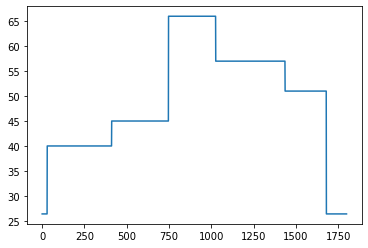

In [3]:
#### Set up run ####

# Import model and model parameters
model = load_model('pid_emulate.h5')
model_params = pickle.load(open('model_params.pkl', 'rb'))

s_x = model_params['Xscale']
s_y = model_params['yscale']
window = model_params['window']

# Run time in minutes
run_time = 30.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Qpid = np.zeros(loops) # Heater values for PID controller
Qlstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with tclab.TCLab() as lab:
    Tsp = np.ones(loops) * lab.T1

# vary temperature setpoint
end = window + 15 # leave 1st window + 15 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp[start:end] = random.randint(30,70)
    
# leave last 120 seconds as room temp
Tsp[-120:] = Tsp[0]

plt.plot(Tsp);

# Part A: Run the controller with the PID, but also output the LSTM for comparison

In [4]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

In [5]:
#-----------------------------------------
# LSTM Controller
#-----------------------------------------

def lstm(T1_m, Tsp_m):
    # Calculate error (necessary feature for LSTM input)
    err = Tsp_m - T1_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp_m,err)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    Q1c = s_y.inverse_transform(Q1c_s)[0][0]
    
    # Ensure Q1c is between 0 and 100
    Q1c = np.clip(Q1c,0.0,100.0)
    
    return Q1c

In [6]:
# Run test
with tclab.TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = time.time()
    prev_time = start_time

    for i in tqdm(range(loops)):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass
        
        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp[i]-T1[i])

        # Calculate PID output
        [Qpid[i],P,ierr,D] = pid(Tsp[i],T1[i],T1[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q1(Qpid[i])
        
        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)
            
        # Generate images to make a gif; only need every 10 images
        if i%10 == 0:
            plt.figure(figsize=(10,4))
            plt.plot(Tsp,'k-',label='SP $(^oC)$')
            plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
            plt.plot(Qpid[:i],'b-',label='$Q_{PID}$ (%)')
            plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
            plt.legend(loc='upper right',fontsize=14)
            plt.ylim((0,100))
            plt.xlabel('Time (s)',size=14)
            plt.xticks(size=12)
            plt.yticks(size=12)

            num = str(i)
            num = num.zfill(len(str(loops)))
            filename='./figures/pid_'+num+'.png'
            plt.savefig(filename)
            plt.close()

TCLab version 0.4.9


  0%|                                                                                         | 0/1800 [00:00<?, ?it/s]

Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 26.38 °C
Temperature 2: 25.70 °C


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [30:00<00:00,  1.00s/it]

TCLab disconnected successfully.


In [7]:
# Generate gif from saved images
images = []
for i in range(0,loops,10):
    num = str(i)
    num = num.zfill(len(str(loops)))
    filename='./figures/pid_'+num+'.png'
    images.append(imageio.imread(filename))
imageio.mimsave('pid_controller.gif', images)

# Part B: Run the controller with just the LSTM

In [8]:
# Run test
with tclab.TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    start_time = time.time()

    for i in tqdm(range(loops)):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass

        # Record time and change in time
        t = time.time()
        tm[i] = t - start_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)

        # Write heater output (0-100)
        lab.Q1(Qlstm[i])

        # Generate images to make a gif; only need every 10 images
        if i%10 == 0:
            plt.figure(figsize=(10,4))
            plt.plot(Tsp,'k-',label='SP $(^oC)$')
            plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
            plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
            plt.legend(loc='upper right',fontsize=14)
            plt.ylim((0,100))
            plt.xlabel('Time (s)',size=14)
            plt.xticks(size=12)
            plt.yticks(size=12)

            num = str(i)
            num = num.zfill(len(str(loops)))
            filename='./figures/lstm_'+num+'.png'
            plt.savefig(filename)
            plt.close()

TCLab version 0.4.9


  0%|                                                                                         | 0/1800 [00:00<?, ?it/s]

Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 30.86 °C
Temperature 2: 28.96 °C


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [30:00<00:00,  1.00s/it]

TCLab disconnected successfully.


In [9]:
# Generate gif
images = []
for i in range(0,loops,10):
    num = str(i)
    num = num.zfill(len(str(loops)))
    filename='./figures/lstm_'+num+'.png'
    images.append(imageio.imread(filename))
imageio.mimsave('lstm_controller.gif', images)